In [74]:
#imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC
import pickle


In [2]:
data= pd.read_csv('../Protected/Data/corpus_processed.csv')

In [3]:
X = data['text_processed']
y = data['label']
X_train, X_test,y_train,y_test =train_test_split(X,y, test_size = .3, stratify = y)

In [4]:
model_params = {}
count = 1

In [9]:
#fits and grid searches a model and transformer, returns the gridsearched model and a table with the best parameters and a few scores
def grid_search_model(transformer, model, param_dict= {}, X_train= X_train, y_train=y_train, X_test=X_test, y_test=y_test, count = count, job_count = 4, verbosity = 1):
    pipe = Pipeline([
        ('transformer', transformer),
        ('model', model)])
    pipe_params = param_dict
    grid = GridSearchCV(estimator = pipe,
                   param_grid = pipe_params,
                   cv = 5,
                    n_jobs = job_count,
                   verbose = verbosity)
    
    grid.fit(X_train,y_train)
    preds=grid.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    plot_confusion_matrix(grid, X_test, y_test, cmap='Purples', values_format='d')
    plt.title(f"Confustion Matrix ")
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    misclassified = (fp+fn)/(tn+tp+fn+fp)
    
    grid.best_params_['score'] = grid.best_score_
    grid.best_params_['f1_score'] = f1_score(y_test,grid.predict(X_test))
    grid.best_params_['auc_score'] = roc_auc_score(y_test,grid.predict(X_test))
    grid.best_params_['specificity'] = round((specificity *100),2)
    grid.best_params_['sensitivity'] = round((sensitivity *100),2)
    grid.best_params_['misclassification_rate'] = round(misclassified * 100,2)
    grid.best_params_['misclassified_rows'] = np.where(y_test != grid.predict(X_test), y_test.index, np.nan)
    model_params[f'model_{model}_{transformer}_{count}'] = grid.best_params_
    model_df = pd.DataFrame.from_dict(model_params, orient='index')
    
    print(f'model_{model}_{transformer}_{count}')
    count +=1
    return grid, model_df, count
    
 


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  6.5min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  8.0min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  9.7min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 11.7min
[Parallel(n_jobs=4)]: Done 3240 out of 3240 | elapsed: 11.8min finished


model_LogisticRegression()_TfidfVectorizer()_1


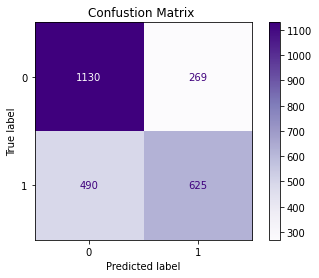

In [6]:
lr_params = {
    "transformer__stop_words" : [None, 'english'],
    "transformer__ngram_range" : [(1,1),(1,2),(1,3),(2,3)],
    "transformer__strip_accents": ['ascii', 'unicode', None],
    "transformer__max_df" :[.9,.8,1.0],
    "transformer__min_df" :[1,3,5],
    "model__C":[1,.01,.001]                     
}
logisticRegression, model_df, count = grid_search_model(TfidfVectorizer(),LogisticRegression(), param_dict = lr_params, count = count)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 11.2min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 19.2min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed: 31.0min
[Parallel(n_jobs=4)]: Done 1440 out of 1440 | elapsed: 44.3min finished


model_SVC()_TfidfVectorizer()_9


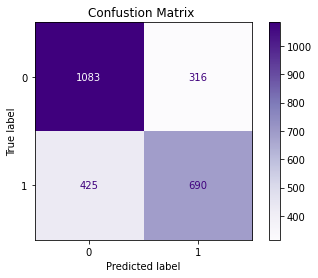

In [77]:
svc_params = {
    "transformer__ngram_range" : [(1,1),(1,2),(2,3)],
    "transformer__strip_accents": ['unicode'],
    "transformer__max_df" :[.8,.9,1.0],
    "transformer__min_df" :[1,5],
    "model__C":[1,.01],
    "model__kernel" : ["linear","poly","rbf","sigmoid"],
    "model__gamma" : ['scale','auto']
    
}
SVC_model, model_df, count = grid_search_model(TfidfVectorizer(),SVC(), param_dict = svc_params, count = count, verbosity = 2)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  5.2min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 35.5min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 58.4min finished


model_BaggingClassifier(base_estimator=RandomForestClassifier())_TfidfVectorizer()_8


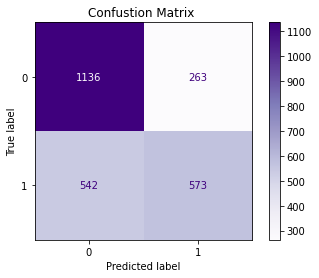

In [32]:

bag_params = {
    "transformer__ngram_range" : [(1,1),(1,2),(1,3)],
    "transformer__max_df" :[.9,1.0],
    "transformer__min_df" :[1,5],
    "model__n_estimators" : [5,10],
    "model__max_features": [1.0,.9]
    
}
bag, model_df, count = grid_search_model(TfidfVectorizer(),BaggingClassifier(base_estimator = RandomForestClassifier()), param_dict = bag_params, count = count, verbosity = 2)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   45.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 960 out of 960 | elapsed:  1.6min finished


model_MultinomialNB()_CountVectorizer()_3


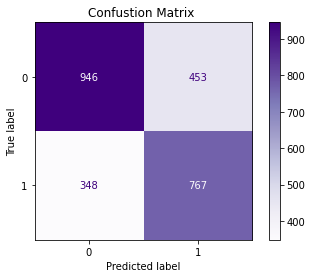

In [12]:
nb_params = {
    'transformer__max_features' :[2000,3000,4000,5000],
    'transformer__min_df' : [2,3],
    'transformer__max_df' : [.9,.95],
    'transformer__ngram_range' : [(1,1),(1,2)],
    "model__alpha":[1,.01,.001],
    "model__fit_prior" : [True, False]
}
n_bayes, model_df, count = grid_search_model(CountVectorizer(),MultinomialNB(), param_dict = nb_params, count = count)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   48.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  7.1min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  9.5min
[Parallel(n_jobs=4)]: Done 2880 out of 2880 | elapsed: 11.2min finished


model_MultinomialNB()_TfidfVectorizer()_10


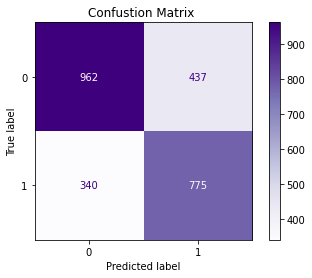

In [79]:
nb_params = {
    'transformer__max_features' :[4000,5000,6000,7000],
    'transformer__min_df' : [2,3],
    'transformer__max_df' : [.85,.9,.95],
    'transformer__ngram_range' : [(1,2),(1,3),(1,4),(2,3)],
    "model__alpha":[1,.01,.001],
    "model__fit_prior" : [True, False]
}
n_bayes_2, model_df, count = grid_search_model(TfidfVectorizer(),MultinomialNB(), param_dict = nb_params, count = count)

In [81]:
pd.pandas.set_option('display.max_columns', None)

model_df

,model__C,transformer__max_df,transformer__min_df,transformer__ngram_range,transformer__stop_words,transformer__strip_accents,score,f1_score,auc_score,specificity,sensitivity,misclassification_rate,misclassified_rows,model__gamma,model__kernel,model__alpha,model__fit_prior,transformer__max_features,model__base_estimator,model__bootstrap_features,model__max_features,model__n_estimators
model_LogisticRegression()_TfidfVectorizer()_1,1.0,0.90,1.0,"(1, 2)",NaN,unicode,0.697407,0.622200,0.684129,80.77,56.05,30.19,"[5276.0, 161.0, 2894.0, nan, nan, nan, nan, 54...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_SVC()_TfidfVectorizer()_2,1.0,0.90,1.0,"(1, 1)",NaN,unicode,0.703886,0.650636,0.696479,77.41,61.88,29.47,"[5276.0, 161.0, 2894.0, nan, nan, nan, nan, na...",scale,rbf,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_SVC()_TfidfVectorizer()_9,1.0,0.80,1.0,"(1, 1)",NaN,unicode,0.703886,0.650636,0.696479,77.41,61.88,29.47,"[5276.0, 161.0, 2894.0, nan, nan, nan, nan, na...",scale,rbf,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_MultinomialNB()_CountVectorizer()_3,NaN,0.90,2.0,"(1, 2)",NaN,NaN,0.705080,0.656959,0.682045,67.62,68.79,31.86,"[5276.0, 161.0, 2894.0, nan, nan, nan, nan, na...",NaN,NaN,1.0,True,4000.0,NaN,NaN,NaN,NaN
model_MultinomialNB()_TfidfVectorizer()_4,NaN,0.90,2.0,"(1, 3)",NaN,NaN,0.710364,0.666094,0.691351,68.76,69.51,30.91,"[5276.0, 161.0, 2894.0, nan, nan, nan, nan, 54...",NaN,NaN,1.0,False,7000.0,NaN,NaN,NaN,NaN
model_MultinomialNB()_TfidfVectorizer()_5,NaN,0.85,2.0,"(1, 3)",NaN,NaN,0.710364,0.666094,0.691351,68.76,69.51,30.91,"[5276.0, 161.0, 2894.0, nan, nan, nan, nan, 54...",NaN,NaN,1.0,False,7000.0,NaN,NaN,NaN,NaN
model_BaggingClassifier(base_estimator=RandomForestClassifier())_TfidfVectorizer()_8,NaN,1.00,5.0,"(1, 3)",NaN,NaN,0.686838,0.587391,0.662955,81.20,51.39,32.02,"[5276.0, 161.0, 2894.0, nan, nan, nan, nan, 54...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,10.0
model_MultinomialNB()_TfidfVectorizer()_10,NaN,0.85,2.0,"(1, 3)",NaN,NaN,0.710364,0.666094,0.691351,68.76,69.51,30.91,"[5276.0, 161.0, 2894.0, nan, nan, nan, nan, 54...",NaN,NaN,1.0,False,7000.0,NaN,NaN,NaN,NaN
model_BaggingClassifier()_TfidfVectorizer()_6,NaN,NaN,NaN,NaN,NaN,NaN,0.659903,0.566891,0.630459,73.27,52.83,35.80,"[nan, 161.0, 2894.0, nan, nan, 3236.0, nan, 54...",NaN,NaN,NaN,NaN,NaN,None,True,0.9,15.0
model_BaggingClassifier()_TfidfVectorizer()_7,NaN,NaN,NaN,NaN,NaN,NaN,0.680020,0.555374,0.653555,85.06,45.65,32.42,"[5276.0, nan, 2894.0, nan, nan, nan, nan, 5428...",NaN,NaN,NaN,NaN,NaN,RandomForestClassifier(),False,0.9,5.0


In [82]:
model_df.to_csv('.././Models/model_df.csv')

In [37]:
data['label'].value_counts(normalize = True)

0    0.556563
1    0.443437
Name: label, dtype: float64

In [80]:
pickle.dump(n_bayes_2.best_estimator_,open('.././Models/n_bayes_2','wb'))
pickle.dump(SVC_model.best_estimator_,open('.././Models/n_bayes_2','wb'))
